This Notebook is created to analyse the cloud data.
-
This is a colection of functions that help to differentiate between valid and false data.
-

In [1]:
import numpy as np
from importlib import reload
import pandas as pd
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from random import random
import matplotlib
import sys

In [2]:
cloud_file = './data/ql_vertmax_20160830.nc'
cloud_data = Dataset(cloud_file)

Let's have a look at the resulting slopes using the 3 different distribution methods
-

timestap 0 has too few clouds: 0
timestap 1 has too few clouds: 0
timestap 2 has too few clouds: 52

--------- variation between log and cum ---------
  minimum at 12:30
  maximum at 7:30
-------------------------------------------------

CPU times: user 866 ms, sys: 163 ms, total: 1.03 s
Wall time: 810 ms


Text(0.5, 0.98, 'cloud size distribution slope')

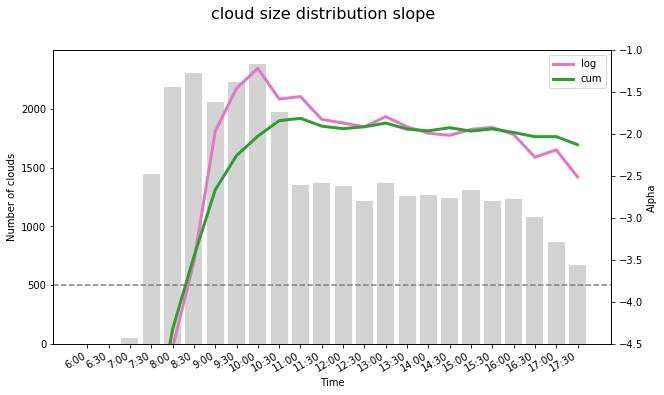

In [3]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt

ref_min     = 1e-6
min_pixel   = 7
bin_n       = 15
bin_min     = 25
bin_max     = 2000
n_cloud_min = 500

start_time  = 6.0
increment   = .5

n_clouds = []
time = np.arange(len(cloud_data.variables['time'][:]))
data = cloud_data.variables['ql'][time,:,:]

time, n_clouds, slope_lin, slope_log, slope_cum = plot_cloud_alpha(data,time,bin_n,bin_min,bin_max,ref_min,min_pixel,n_cloud_min)

slope_var = []
for i in range(len(slope_log)):
    if np.isnan(slope_log[i]):
        slope_var.append(slope_log[i])
    else:
        slope_var.append(np.abs(slope_log[i]-slope_cum[i]))

time_labels = get_time_labels(start_time, increment, len(time))

print('\n--------- variation between log and cum ---------')
print('  minimum at',time_labels[np.nanargmin(slope_var)+len(cloud_data.variables['time'][:])-len(time)])
print('  maximum at',time_labels[np.nanargmax(slope_var)+len(cloud_data.variables['time'][:])-len(time)])
print('-------------------------------------------------\n')

axes = plt
axes.figure(figsize=(10,6))
axes.bar(time, n_clouds, color='lightgrey')
axes.axhline(y=n_cloud_min, color='grey', linestyle='--')

axes.xlabel('Time')
axes.ylabel('Number of clouds')

axes2 = axes.twinx()
axes2.set_ylabel('Alpha')

#axes2.plot(time_labels, slope_lin, linewidth=3, color='tab:red', label='lin')
axes2.plot(time_labels, slope_log, linewidth=3, color='tab:pink', label='log')
axes2.plot(time_labels, slope_cum, linewidth=3, color='tab:green', label='cum')

plt.ylim(-4.5,-1)
plt.gcf().autofmt_xdate()
plt.legend()
plt.suptitle('cloud size distribution slope', fontsize=16)

#plt.savefig('log_cum_slopes_clouds.pdf',bbox_inches='tight')

Let's have a look at the clouds for one specific timestep
-
- by default the timestep is selected where the cum and log slopes are the furthest apart

- a cloud size histogram for this timestep is also created

[notice] cell above needs to be executed first, to obtain slopes_log and slope_cum

CPU times: user 611 ms, sys: 19.5 ms, total: 630 ms
Wall time: 632 ms


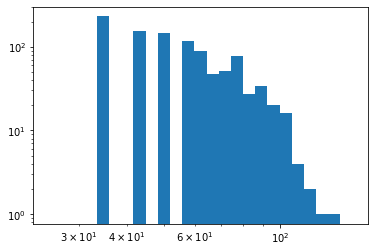

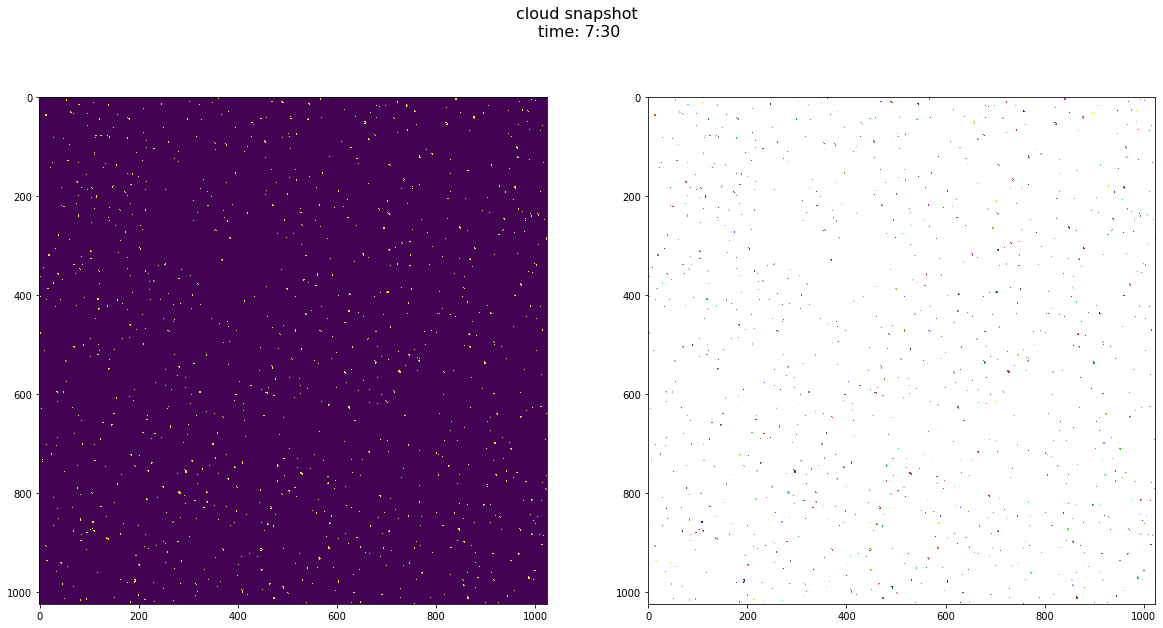

In [4]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt
from random import random


hist_bins   = 25       #number of bins used for the histogram
buffer_size = .5     #buffer_size given as a percentage of the full domain's length


colors = [(0.5,0.5,0.5)] + [(random(),random(),random()) for i in range(1000)]
random_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('random_cmap', colors, N=1000)

absolute = []
for i in range(len(slope_log)):
    if np.isnan(slope_log[i]):
        absolute.append(slope_log[i])
    else:
        absolute.append(np.abs(slope_log[i]-slope_cum[i]))

timestep = np.nanargmax(absolute)+len(cloud_data.variables['time'][:])-len(time)
        
# marks everything above ref_min as a cloud
cloud_2D_mask = np.zeros_like(cloud_data.variables['ql'][timestep,:,:])
cloud_2D_mask[cloud_data.variables['ql'][timestep,:,:] > ref_min] = 1

# calculates how many clouds exist in cloud_2D_mask, returns total number of clouds
labeled_clouds, A_buf, n_buffer, cloud_center_x, cloud_center_y, cloud_pixels = cluster_2D(cloud_2D_mask,buffer_size)

#Grosse jeder wolken
label, cl_pixels = np.unique(labeled_clouds.ravel(),return_counts=True)
cl_size = np.sqrt(cl_pixels*25.*25.)

plt.hist(cl_size[1:],bins=np.logspace(np.log10(min(cl_size[1:])),np.log10(max(cl_size[1:])), hist_bins+1))
plt.yscale('log')
plt.xscale('log')

masked_clouds = np.ma.masked_where(labeled_clouds<1,labeled_clouds)
fig,ax = plt.subplots(1,2,figsize=(20,10))
fig.suptitle('cloud snapshot \ntime: %s' %time_labels[timestep], fontsize=16)

im1  =ax[0].imshow(cloud_2D_mask)
im1  =ax[1].imshow(masked_clouds,cmap=random_cmap)
#plt.savefig('cloud_snapshot_ts%i_20160830.pdf'%timestep,bbox_inches='tight')

Now where we've seen a snapshot of the cloud field, let's investigate the slope calculation
-
- areas covered in light gray have been filtered out and did not influence the slope calculation

[notice] if not further specified the timestep from above is used.


---------------------------------------------
  number of clouds in this timestep: 1449
---------------------------------------------

CPU times: user 192 ms, sys: 24 ms, total: 216 ms
Wall time: 149 ms


/home/till/Desktop/SHK/Jupyter/SHK_projects-master/slopes_and_binning.py:349: RuntimeWarning: divide by zero encountered in log
  m2, b2 = np.polyfit(np.log(x_bins_log_mm_cut),np.log(CSD_cut), 1)


Text(0.5, 0.98, 'size distribution \ntime: 7:30')

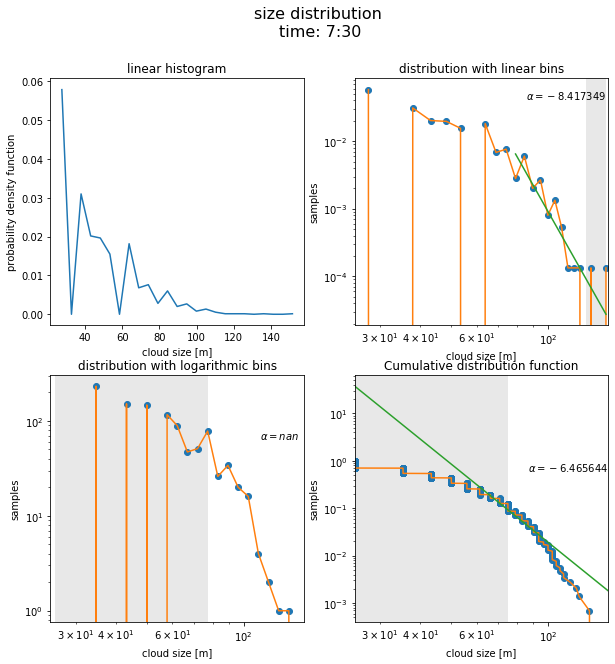

In [5]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt

#timestep = 10

ref_min   = 1e-6
min_pixel = 9
n_bins    = 25
bin_min   = 5
bin_max   = 500
show_plt  = True

fig,m1,m2,m3 = cloud_size_dist('ql',timestep,n_bins,bin_min,bin_max,ref_min,cloud_data,min_pixel,show_plt)
fig.suptitle('size distribution \ntime: %s' %time_labels[timestep], fontsize=16)
#plt.savefig('cloud_slopes_4rer_time_%i.pdf'%time_labels[timestep],bbox_inches='tight')

Next we take a look at the spacial organization of clouds using the method described in Neggers et. al, 2018
-
- if log_binning = False is selected the algorithm uses linear bins

[notice] timestep should have been selected in the cell above. Otherwise, timestep needs to be specified.

min cloud area: 75.0 
max cloud area: 154.1103500742244
timestep: 3


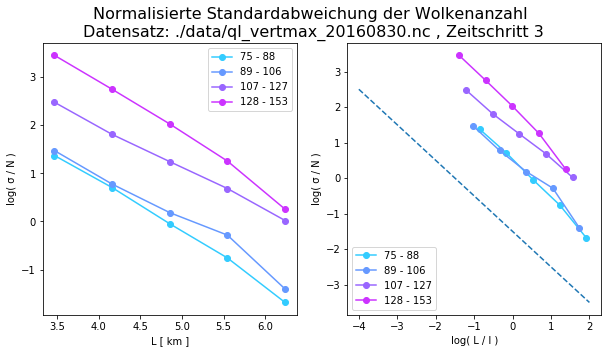

CPU times: user 1.72 s, sys: 19.5 ms, total: 1.74 s
Wall time: 1.74 s


In [6]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#timestep = 10

subdomains     = [2,4,8,16,32]
log_binning    = True

inbetween_subs = True
n_bins         = 4                 #number of bins per subdomain wich the histogram holds
ref_min        = 1e-6
min_pixel      = 9
buffer_size    = .5           #buffer_size given as a percentage of the full domain's length


l2D = cloud_data.variables['ql'][timestep,:,:]
l2D_bi = np.zeros_like(l2D).astype(int)
l2D_bi[l2D>ref_min]=1

labeled_clouds, l2D_bi_buf, n_buffer, cloud_center_x, cloud_center_y, cloud_pixels = cluster_2D(l2D_bi,buffer_size)

cloud_size = np.sqrt(np.asarray(cloud_pixels))*25.
cloud_center_x = np.asarray(cloud_center_x)
cloud_center_y = np.asarray(cloud_center_y)

new_arr = np.zeros_like(l2D_bi).astype(float)
new_arr[cloud_center_x,cloud_center_y] = cloud_size

var = []
N_mean =  []
L = []

cloud_area_min = np.sqrt(min_pixel)*25.
cloud_area_max = np.max(cloud_size)
print ('min cloud area:',cloud_area_min,'\nmax cloud area:',cloud_area_max)
print ('timestep:',timestep)

for n_x_slices in subdomains:
    n_y_slices = n_x_slices
    x_split = int(l2D_bi.shape[0] / n_x_slices)
    y_split = int(l2D_bi.shape[0] / n_y_slices)
    
    dist = []
    var_sub = []
    N_mean_sub = []
    
    L.append(len(new_arr)/n_x_slices)
    for y in range(n_y_slices):
        for x in range(n_x_slices):
            tmp_sub = new_arr[y*y_split:(y+1)*y_split,x*x_split:(x+1)*x_split]
            tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
            if (log_binning):
                n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
            else:
                n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
            dist.append(n_cl_per_bin)
            
    if inbetween_subs:
        for y in range(n_y_slices):
            for x in range(n_x_slices-1):
                tmp_sub = new_arr[y*y_split:(y+1)*y_split,int((x+.5)*x_split):int((x+1.5)*x_split)]
                tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
                if log_binning:
                    n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
                else:
                    n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
                dist.append(n_cl_per_bin)

        for y in range(n_y_slices-1):
            for x in range(n_x_slices):
                tmp_sub = new_arr[int((y+.5)*y_split):int((y+1.5)*y_split),x*x_split:(x+1)*x_split]
                tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
                if log_binning:
                    n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
                else:
                    n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
                dist.append(n_cl_per_bin)

    dist = np.asarray(dist)
    
    for i in range(n_bins):
        N_mean_sub.append(np.mean(dist[:,i]))
        var_sub.append(np.sqrt(np.sum((dist[:,i]-N_mean_sub[i])**2)/len(dist[:,0])))

    var.append(var_sub)
    N_mean.append(N_mean_sub)
    
N_mean = np.asarray(N_mean)
var = np.asarray(var)

fig,ax = plt.subplots(1,2,figsize=(10,5))
y_axis = np.log(var/N_mean)

for i in range(n_bins):
    x_axis = np.log(L/l[i])
    m, b = np.polyfit(x_axis, y_axis[:,i], 1)
    
    color = plt.cm.cool((i+1)/(n_bins+1))
    im1 = ax[0].plot(np.log(L),y_axis[:,i], '-o', label='%i - %i'%(int(l[i]),int(l[i+1])-1), color=color)
    im2 = ax[1].plot(x_axis,y_axis[:,i], '-o', label='%i - %i'%(int(l[i]),int(l[i+1])-1), color=color)
    
im1 = ax[1].plot([-4,2],np.polyval([-1,-1.5],[-4,2]),'--')

fig.suptitle('Normalisierte Standardabweichung der Wolkenanzahl \nDatensatz: %s , Zeitschritt %i' % (cloud_file,timestep), fontsize=16)

ax[0].legend(loc='best')
ax[0].set_xlabel('L [ km ]')
ax[0].set_ylabel('log( σ / N )')

ax[1].legend(loc='best')
ax[1].set_xlabel('log( L / l )')
ax[1].set_ylabel('log( σ / N )')

#plt.savefig('organization_clouds_ts%i.png'%timestep)
plt.show()

Next up let's calculate the organization slope for a whole timeseries
-
- if log_binning = False is selected the algorythm uses linear bins

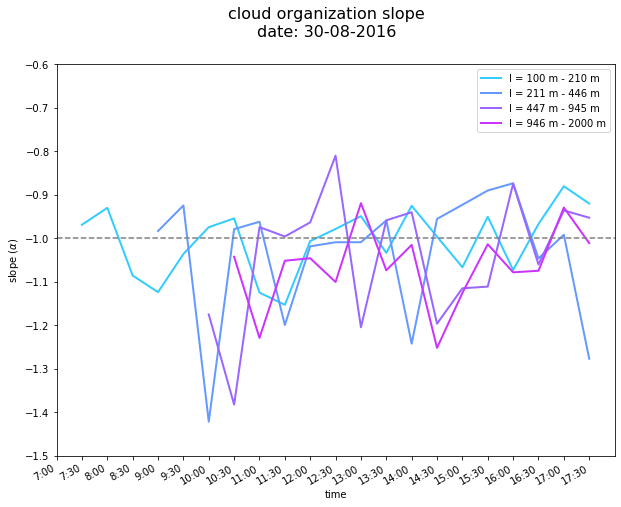

CPU times: user 23 s, sys: 303 ms, total: 23.3 s
Wall time: 23.1 s


In [7]:
%%time
import numpy as np
from importlib import reload
import organization
from organization import *
reload(organization)
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


subdomains       = [2,4,8,16,32]      #number of subdomains in both x and y-axis
n_bins           = 4                  #number of bins (cloud size) which devide the whole cloud size range
log_binning      = True
inbetween_subs   = True
buffer_size      = .5                 #buffer_size given as a percentage of the full domain's length. this buffer is needed in cluster_2D() to compensate periodic boundaries
ref_min          = 1e-6

percentile       = False              #if set to False min_size and max_size will be used as boundaries for the size distribution
lower_percentile = 25
upper_percentile = 99
min_size         = 100
max_size         = 2002

start_time       = 6.0
increment        = .5


time_len = len(cloud_data.variables['ql'][:,0,0])

cloud_size = []
cloud_center_x = []
cloud_center_y = []
size = []
valid_time = []
for timestep in range(time_len):
    l2D = cloud_data.variables['ql'][timestep,:,:]
    l2D_bi = np.zeros_like(l2D).astype(int)
    l2D_bi[l2D>ref_min]=1
    if (len(l2D_bi[l2D_bi==1])>100):
        valid_time.append(timestep)
        labeled_clouds, l2D_bi_buf, n_buffer, center_x, center_y, cloud_pixels = cluster_2D(l2D_bi,buffer_size)
        cloud_size.append(np.sqrt(cloud_pixels)*25.)
        cloud_center_x.append(center_x)
        cloud_center_y.append(center_y)
        size.extend(np.sqrt(cloud_pixels)*25.)
    else:
        cloud_size.append(np.nan)
        cloud_center_x.append(np.nan)
        cloud_center_y.append(np.nan)

domain_size = len(l2D)
if percentile:
    min_size = np.percentile((size), lower_percentile)
    print(lower_percentile,'th percentile -> ',np.round(min_size,1),'m')
    max_size = np.percentile((size), upper_percentile)
    print(upper_percentile,'th percentile -> ',np.round(max_size,1),'m')
    
f = variability(cloud_center_x, cloud_center_y, cloud_size, valid_time, start_time, increment, domain_size, subdomains, n_bins, min_size, max_size, log_binning, inbetween_subs, show_subs=False)
plt.suptitle('cloud organization slope\ndate: %s-%s-%s' %(cloud_file[-5:-3],cloud_file[-7:-5],cloud_file[-11:-7]), fontsize=16)
#plt.savefig('organization_clouds_%s.pdf' %(cloud_file[-11:-3]),bbox_inches='tight')
plt.show()

This last segment is basically the same as the one above. 
-
There is just the addition of os.path which scans your current directory and every subdirectory for .nc files and runs them all in a loop.
-
- if log_binning = False is selected the algorythm uses linear bins

Path: /home/till/Desktop/SHK/Jupyter/SHK_projects-master/


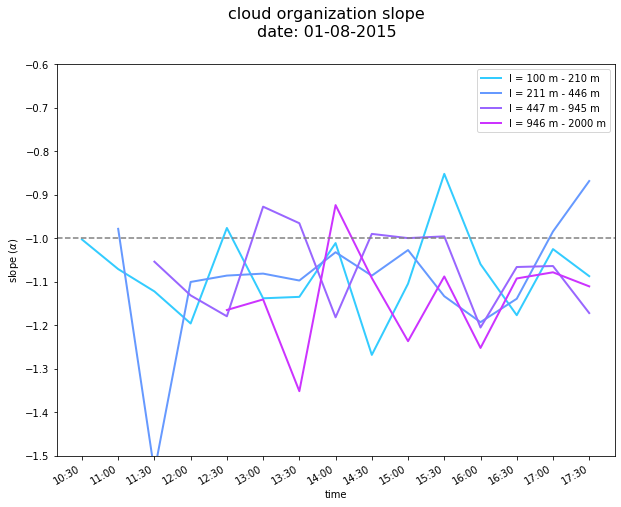

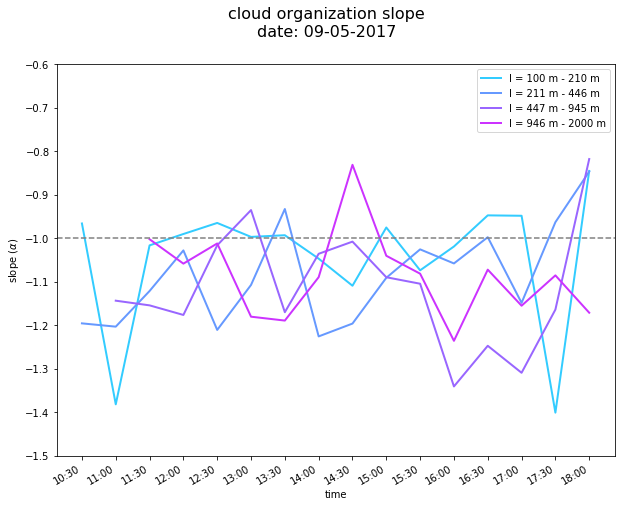

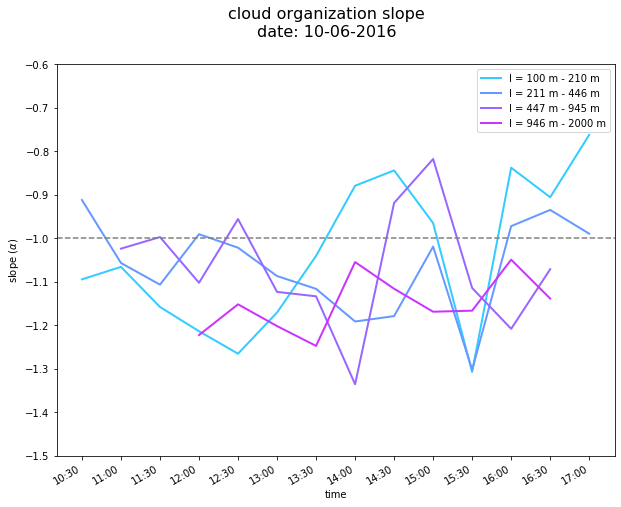

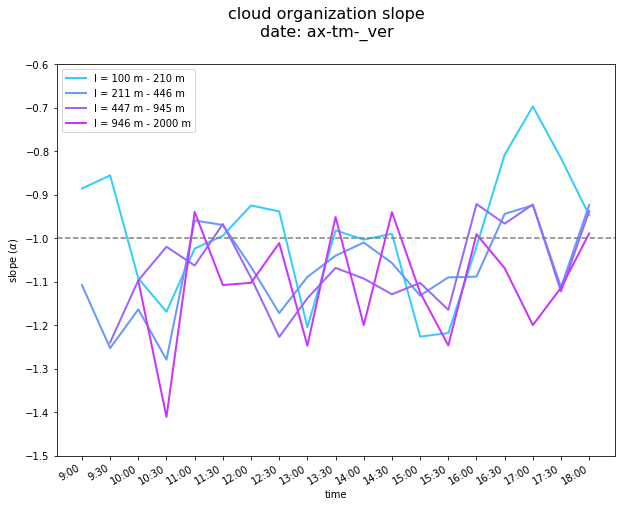

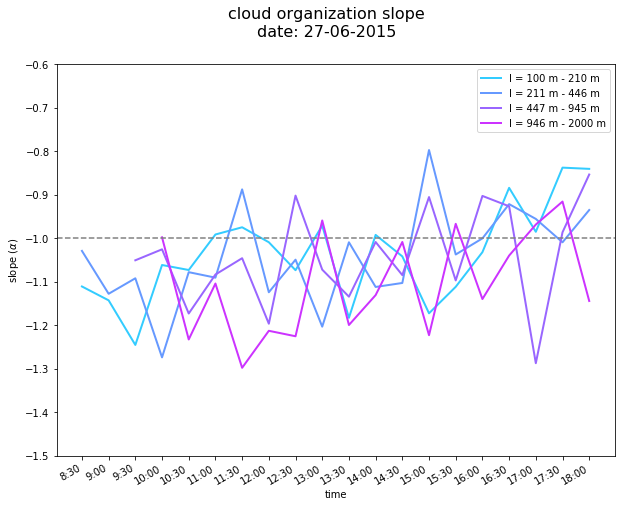

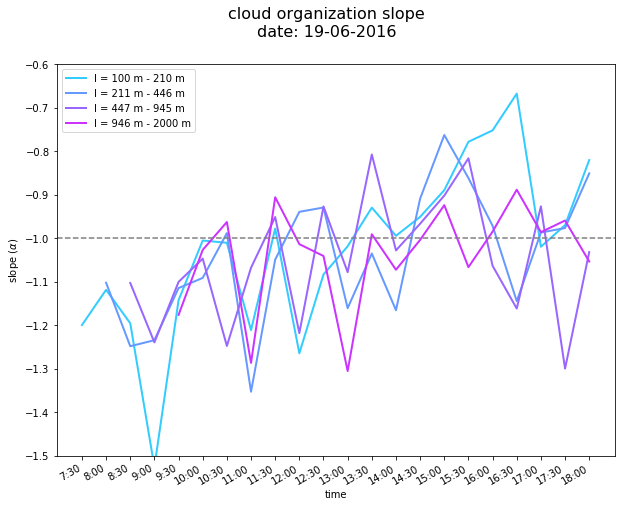

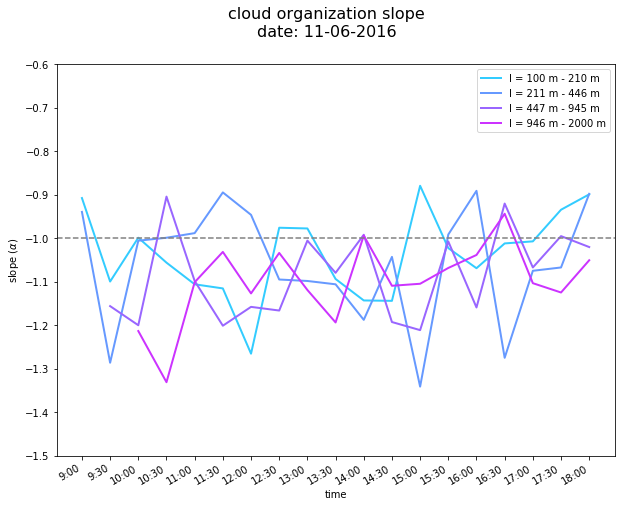

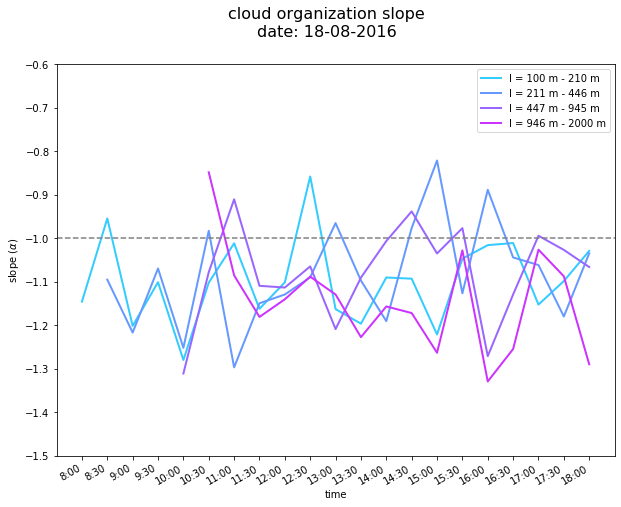

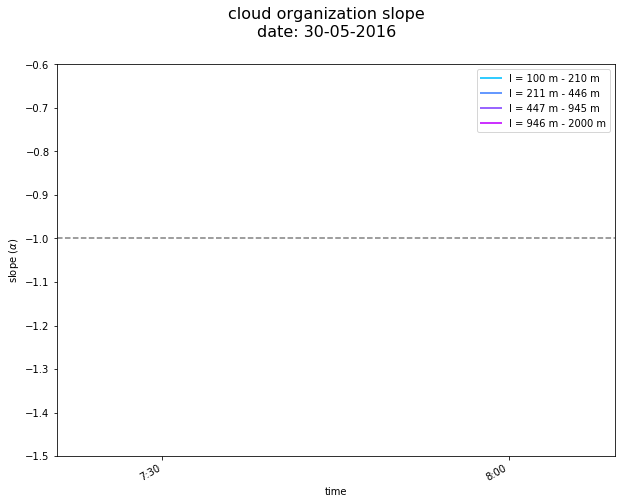

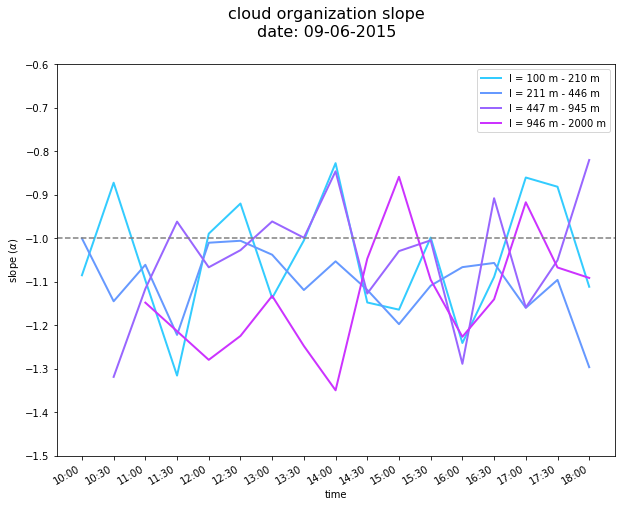

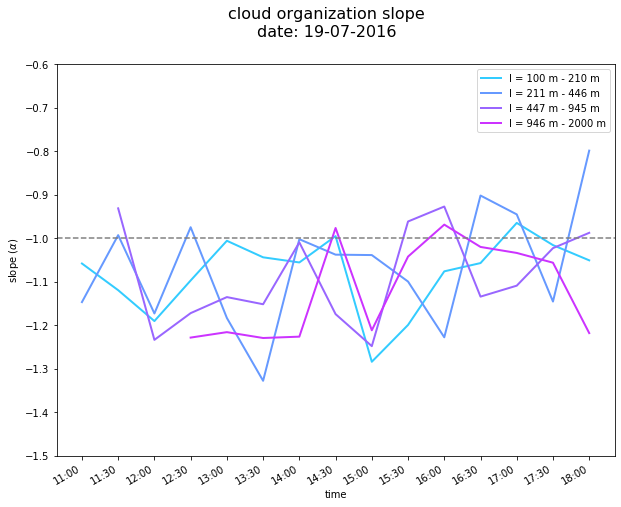

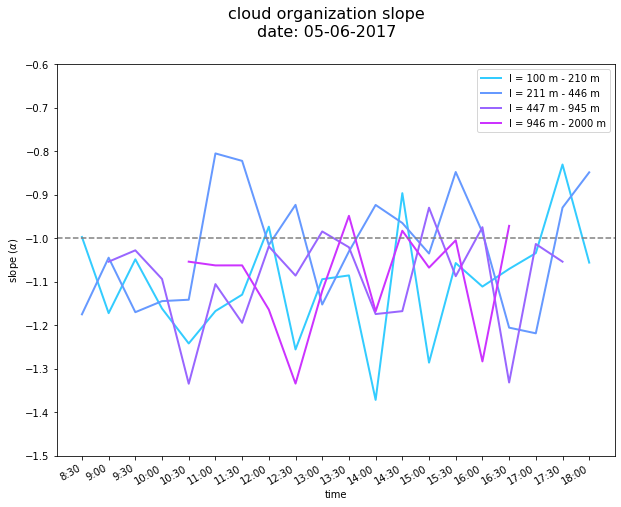

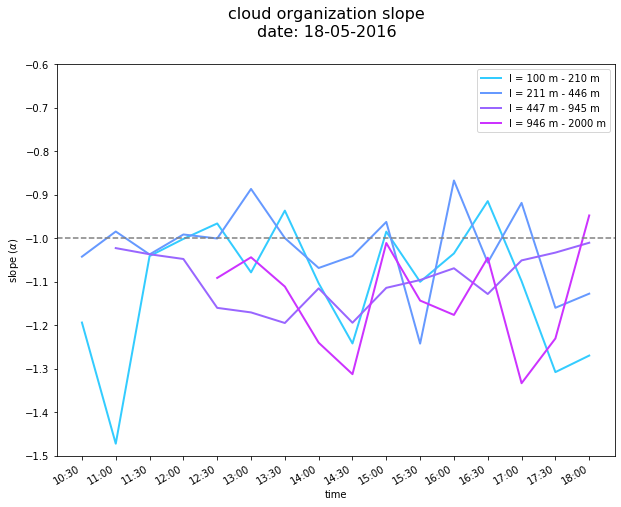

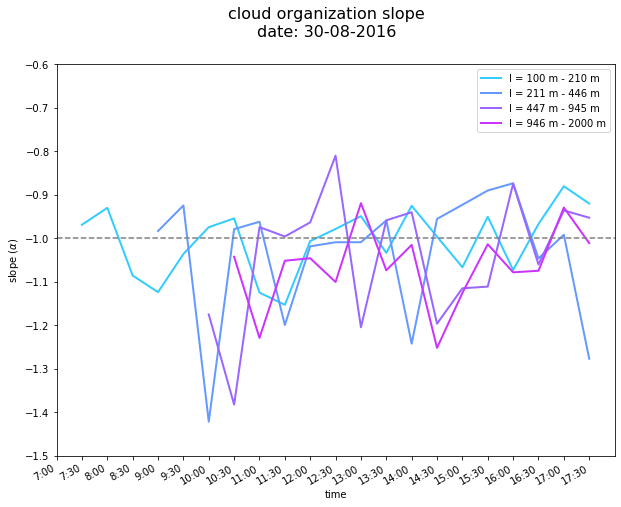

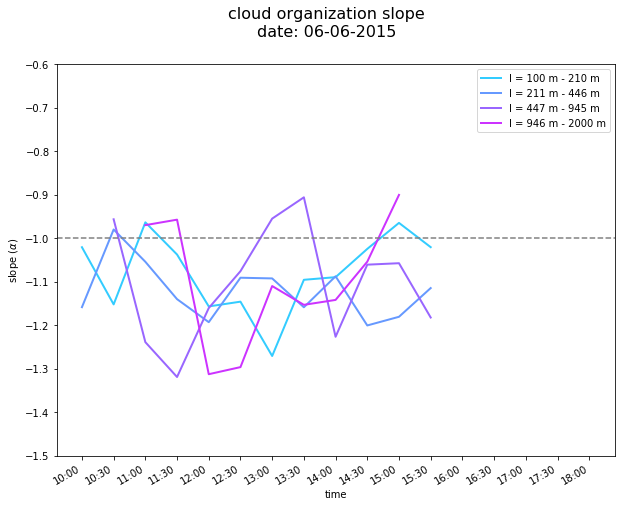

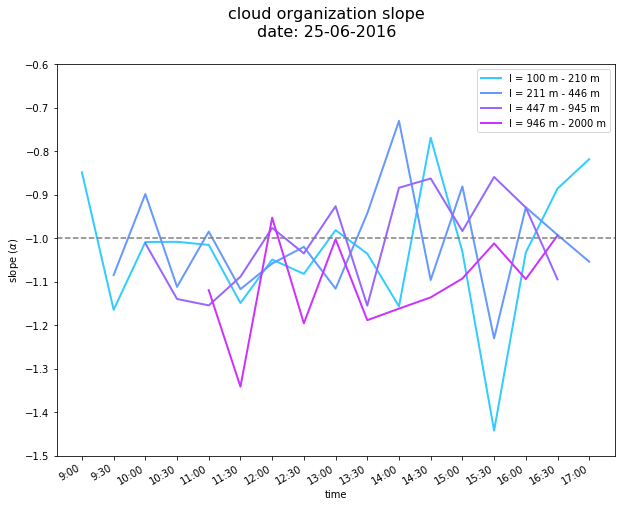

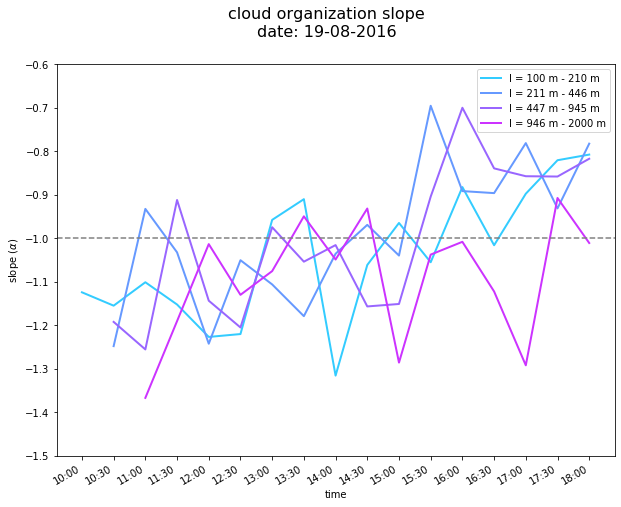

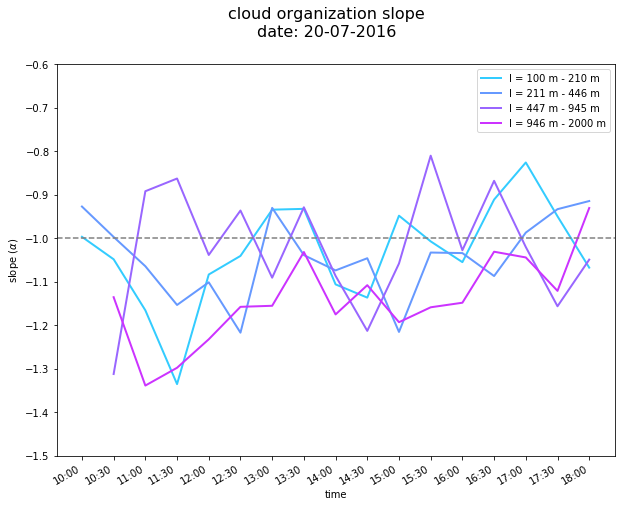

CPU times: user 5min 24s, sys: 6.03 s, total: 5min 30s
Wall time: 5min 27s


In [8]:
%%time
import numpy as np
from importlib import reload
import organization
from organization import *
reload(organization)
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
import glob


subdomains       = [2,4,8,16,32]      #number of subdomains in both x and y-axis
n_bins           = 4                  #number of bins (cloud size) which devide the whole cloud size range
log_binning      = True
inbetween_subs   = True
buffer_size      = .5                 #buffer_size given as a percentage of the full domain's length. this buffer is needed in cluster_2D() to compensate periodic boundaries
ref_min          = 1e-6

percentile       = False              #if set to False min_size and max_size will be used as boundaries for the size distribution
lower_percentile = 25
upper_percentile = 99
min_size         = 100
max_size         = 2002

start_time       = 6.0
increment        = .5


walk_dir = sys.argv[1]
path = os.path.abspath(walk_dir)
path = path[:-2]
print('Path:',path)
files = [f for f in glob.glob(path + "**/*.nc", recursive=True)]

for cloud_file in files:
    cloud_data = Dataset(cloud_file)
    
    time_len = len(cloud_data.variables['ql'][:,0,0])

    cloud_size = []
    cloud_center_x = []
    cloud_center_y = []
    size = []
    valid_time = []
    for timestep in range(time_len):
        l2D = cloud_data.variables['ql'][timestep,:,:]
        l2D_bi = np.zeros_like(l2D).astype(int)
        l2D_bi[l2D>ref_min]=1
        if (len(l2D_bi[l2D_bi==1])>100):
            valid_time.append(timestep)
            labeled_clouds, l2D_bi_buf, n_buffer, center_x, center_y, cloud_pixels = cluster_2D(l2D_bi,buffer_size)
            cloud_size.append(np.sqrt(cloud_pixels)*25.)
            cloud_center_x.append(center_x)
            cloud_center_y.append(center_y)
            size.extend(np.sqrt(cloud_pixels)*25.)
        else:
            cloud_size.append(np.nan)
            cloud_center_x.append(np.nan)
            cloud_center_y.append(np.nan)

    domain_size = len(l2D)
    if percentile:
        min_size = np.percentile((size), lower_percentile)
        print(lower_percentile,'th percentile -> ',np.round(min_size,1),'m')
        max_size = np.percentile((size), upper_percentile)
        print(upper_percentile,'th percentile -> ',np.round(max_size,1),'m')

    f = variability(cloud_center_x, cloud_center_y, cloud_size, valid_time, start_time, increment, domain_size, subdomains, n_bins, min_size, max_size, log_binning, inbetween_subs, show_subs=False)
    plt.suptitle('cloud organization slope\ndate: %s-%s-%s' %(cloud_file[-5:-3],cloud_file[-7:-5],cloud_file[-11:-7]), fontsize=16)
    #plt.savefig('organization_clouds_%s.pdf' %(cloud_file[-11:-3]),bbox_inches='tight')
    plt.show()